# Analyzing NYC High School Data

## A DataQuest Guided Project

This project explores NYC High School Data for correlations between SAT scores and variables such as demographics, class size, and school survey results. The first step to analyzing the data was to combine multiple datasets into a single, clean, Pandas Dataframe. Afterwards, a few relationships were explored using plotting and mapping techniques.

### Data Cleaning
**Read in the data**

In [38]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

**Read in the surveys**

In [39]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

#join the 2 datasets by appending
survey = pandas.concat([all_survey, d75_survey], axis=0)

#create a new column with dbn in capital letters
survey["DBN"] = survey["dbn"]

#create a list of the relevant survey_fields
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

#add the relevant data to the dictionary
survey = survey.loc[:,survey_fields]
data["survey"] = survey

**Add DBN columns**

In [40]:
#standardize column names for merge key
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

#pad csd if string only has 1 digit
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

**Convert columns to numeric**

In [41]:
#convert scores to numeric and get an total sat score
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#create functions to extract latitude and longitude from string
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

**Condense datasets**

In [42]:
#condense datasets so to eliminate multiple joins by filtering or aggregating
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

**Convert AP scores to numeric**

In [43]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

**Combine the datasets**

In [44]:
#initialize a dataframe and merge the rest of the data in
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

**Add a school district column for mapping**

In [45]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Explore Relationships

In [46]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

* SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score (as expected)

Other relationships are further explored below:

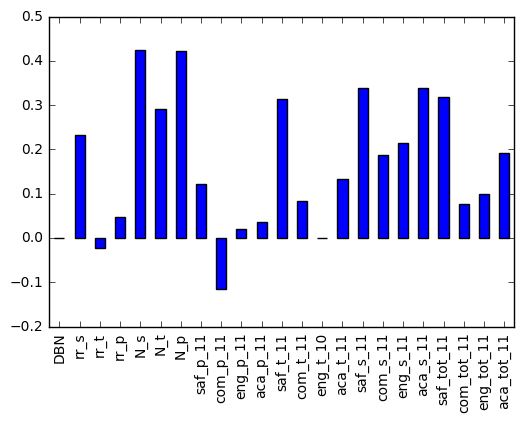

In [47]:
%matplotlib inline
#use pandas plotting http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html
correlations[survey_fields].plot.bar()


* rr_s: Student Response Rate
* rr_t: Teacher Response Rate
* rr_p: Parent Response Rate
* N_s: Number of student respondents
* N_t: Number of teacher respondents
* N_p: Number of parent respondents
* saf: Safety & Respect score
* com: Communication score
* eng: Engagement score
* aca: Academeic Expectation score
<br /><br />
* total_enrollment correlates strongly positively with sat_score along with other columns that are proxies for enrollment, like total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS
<br /><br />
* How highly teachers and students rated safety at the school (saf_t_11, and saf_s_11) correlates with sat_score
<br /><br />
* How highly students rated academic standards (aca_s_11) correlates with sat_score, but this does not hold for teachers and parents (aca_p_11 and aca_t_11).
<br /><br />
### Student Safety Score

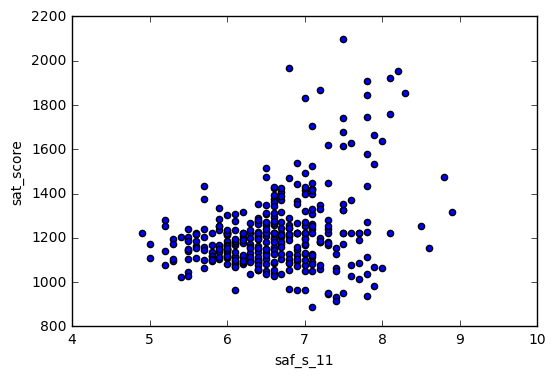

In [48]:
combined.plot.scatter(x='saf_s_11', y='sat_score');

There is a positive correlation between student safety score and sat score. The correlation is not very strong but there is a group of outliers in the higher safety score region with high sat scores. This correlation makes sense because a safe learning environment allows teachers/students to focus on their teaching/learning. Additionally, it could be an indicator of other factors such as school funding, or poverty levels of the community in/around the school (i.e. low poverty levels links to educated parents which perpetuates through to the upbringing of the students). No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Mapping Safety Scores

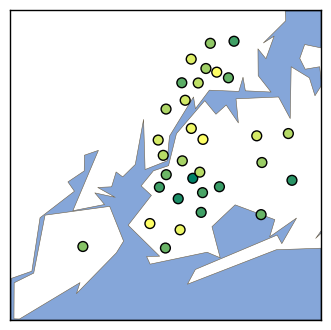

In [49]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

On this map, green indicates low safety scores and yellow indicates high safety scores. 

Lower Brooklyn, Manhattan, and parts of Queens appear to be the safest and there's a big chunk of Brooklyn with low safety scores.

### Racial Differences in SAT Scores

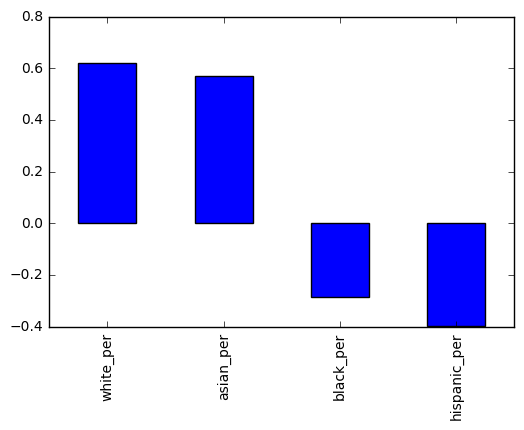

In [50]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations[races].plot.bar()

Notably, schools with higher white and asian populations have a positive correlation with SAT score whereas higher black and hispanic populations have a negative correlation. This is not to say that there is a causal relationship between race and sat score, but related to other communal factors surrounding these ethnicities in New York. Some of those things may be parent's education level, socioeconomic status, or language barriers to name a few.

### Closer look into Hispanic vs SAT Score Correlation

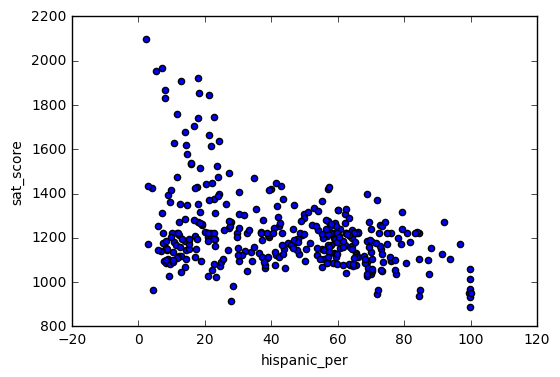

In [51]:
combined.plot.scatter(x='hispanic_per', y='sat_score');

We can see a number of outliers on both ends of the spectrum.

What are the schools that have the highest percentages of hispanic people?

In [52]:
hispanic_schools = combined[combined['hispanic_per']>95]
hispanic_schools['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A number of these schools appear to serve as transitional schools for Spanish speaking immigrants. Lower SAT scores would make sense due to the language barrier of the students.

### Gender Differences in SAT Score

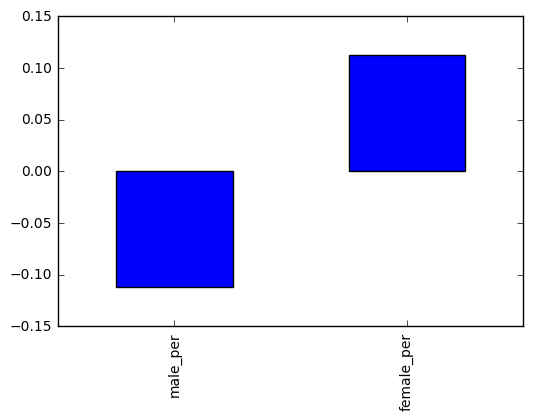

In [53]:
genders = ["male_per", "female_per"]
correlations[genders].plot.bar()

There is a slight negative correlation with higher male percentages and a slight positive correlation with higher female percentages.

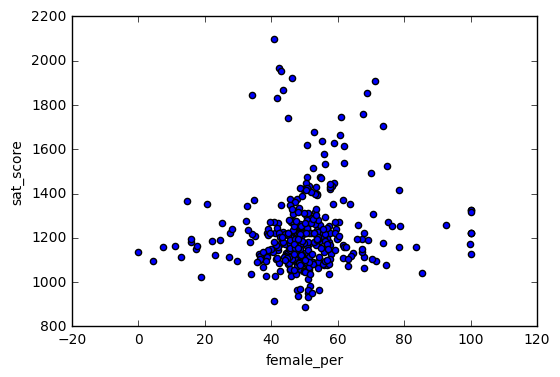

In [54]:
combined.plot.scatter(x='female_per', y='sat_score');

There doesn't appear to be much of a correlation.

There is a small cluster of schools with female percentage over 60 and SAT scores above 1700. Those schools are listed below. These schools appear to be college prep schools.

In [55]:
female_schools = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
female_schools['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### AP Test Takers

0.0571708139077


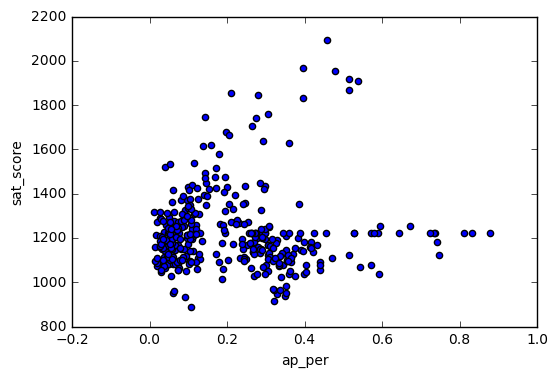

In [56]:
combined["ap_per"] = combined["AP Test Takers "] /combined["total_enrollment"] 
print(combined["ap_per"].corr(combined["sat_score"]))
combined.plot.scatter(x='ap_per', y='sat_score')

There's a very slight positive correlation with AP Test Taker percentages of total enrollment and SAT score.


### Total Enrollment in SAT Score

0.367856916988


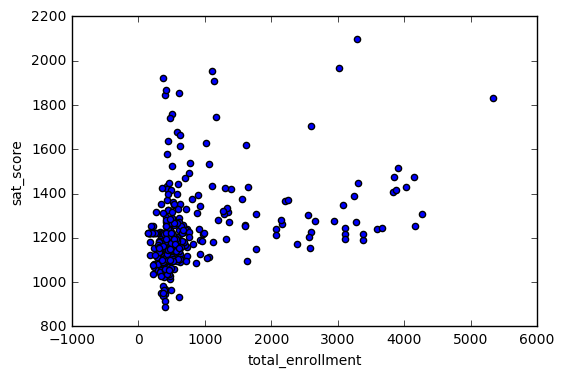

In [57]:
print(combined["total_enrollment"].corr(combined["sat_score"]))
combined.plot.scatter(x='total_enrollment', y='sat_score')

There is a positive correlation with total enrollment and SAT score. This seems counter intuitive as you'd imagine smaller schools would have more focus on the students, but total enrollment may indicate larger schools with more funding and program availability. 

### Mapping of SAT Scores

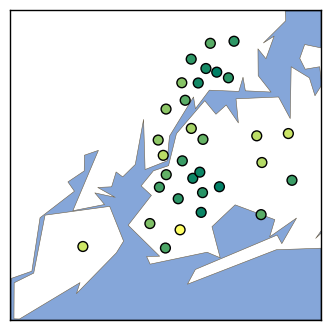

In [58]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["sat_score"], cmap="summer")
plt.show()

The highest scores come from lower Brooklyn, Queens and Manhattan areas in general. 

### Conclusion

Combining and cleanig the data allowed us to slice and dice the data in various ways to uncover correlations and explore relationships. Additionally, mapping the data points offered interesting visuals that offered more insights. An important consideration to note is that correlations do not indicate causation, and a deeper regression analysis would need to be performed to single out variables to confidently determine if there is any causation with different factors.